# Demo de implementación de un algoritmo de Bandadas de Pájaros (Particle Swarm Optimization o PSO) para resolver el problema de encontrar un punto defino al azar en un plano
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

0) Preparar el ambiente:

In [8]:
!pip install deap

1) Importar librerías:

In [9]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

import operator

from deap import base
from deap import creator
from deap import tools
from deap import benchmarks

print("\nLibrerías importadas")


Librerías importadas


2) Inicializar objetos de DEAP para utilizar e indicar parámetros de PSO:

In [10]:
## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Particle", list, fitness=creator.FitnessMax, speed=list, 
    smin=None, smax=None, best=None)

def generate(size, pmin, pmax, smin, smax):
    part = creator.Particle(random.uniform(pmin, pmax) for _ in range(size)) 
    part.speed = [random.uniform(smin, smax) for _ in range(size)]
    part.smin = smin
    part.smax = smax
    return part

def updateParticle(part, best, phi1, phi2):
    u1 = (random.uniform(0, phi1) for _ in range(len(part)))
    u2 = (random.uniform(0, phi2) for _ in range(len(part)))
    v_u1 = map(operator.mul, u1, map(operator.sub, part.best, part))
    v_u2 = map(operator.mul, u2, map(operator.sub, best, part))
    part.speed = list(map(operator.add, part.speed, map(operator.add, v_u1, v_u2)))
    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin:
            part.speed[i] = math.copysign(part.smin, speed)
        elif abs(speed) > part.smax:
            part.speed[i] = math.copysign(part.smax, speed)
    part[:] = list(map(operator.add, part, part.speed))

toolbox = base.Toolbox()
toolbox.register("particle", generate, size=2, pmin=-6, pmax=6, smin=-3, smax=3)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle, phi1=2.0, phi2=2.0)

print("\nObjetos de PSO definidos")


Objetos de PSO definidos


/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [54]:
### FUNCIÓN HEURÍSTICA

# define una posición random
POS_RANDOM_EVALUAR = (random.uniform(-1000, 1000),  random.uniform(-1000, 1000))
print("** Posición al Azar a Buscar: ", POS_RANDOM_EVALUAR, "**")

# definimos la función a evaluar
def funcHeuristica(particula):
    sqerrors = ((x - y)**2 for x, y in zip(particula, POS_RANDOM_EVALUAR))
    return (-1 * math.fsum(sqerrors) / len(POS_RANDOM_EVALUAR)),
    
# registra la función que se va a evaluar
toolbox.register("evaluate", funcHeuristica)

print("\nFunción Heurística definida")

** Posición al Azar a Buscar:  (605.3772661393361, 12.460190743827297) **

Función Heurística definida


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [62]:
### Parámetros de la Corrida

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 300

# Cantidad de Particulas
CANT_PARTICULAS = 5

# Indica si se muestra el detalle de cada ciclo
MUESTRA_DETALLE = False

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


In [63]:
## EJECUCIÓN DE LA CORRIDA

# Define la población inicial
partPobla = toolbox.population(n=CANT_PARTICULAS)

# vectores auxiliares 
ciclo = 1    
mejorPart = None
ciclosParticulas = []

while (ciclo < CANT_CICLOS):

    if MUESTRA_DETALLE:
        print("\n-- Ciclo  %i --" % ciclo)        

    # Evalúa las partículas
    for part in partPobla:
       
        # Genera una copia de las partículas para el gráfico
        clonePart = list(map(toolbox.clone, part))
        ciclosParticulas.append( clonePart )

        part.fitness.values = toolbox.evaluate(part)
        if not part.best or part.best.fitness < part.fitness:
            part.best = creator.Particle(part)
            part.best.fitness.values = part.fitness.values

        if not mejorPart or mejorPart.fitness < part.fitness:
            mejorPart = creator.Particle(part)
            mejorPart.fitness.values = part.fitness.values

    # Actualiza las partículas
    for part in partPobla:
        toolbox.update(part, mejorPart)
    
    if MUESTRA_DETALLE:
        print(" Mejor Individuo:", mejorPart, " ( ", mejorPart.fitness.values[0], " ) ")

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --" % ciclo )
print("** Posición al Azar a Buscar: ", POS_RANDOM_EVALUAR, "**")
print("= Mejor Individuo de la Corrida:", mejorPart, " ( ", mejorPart.fitness.values[0], " ) ==")


-- Corrida Finalizada en 300 ciclos --
** Posición al Azar a Buscar:  (605.3772661393361, 12.460190743827297) **
= Mejor Individuo de la Corrida: [605.3169255640424, 12.496292699259778]  (  -0.0024721681064122053  ) ==


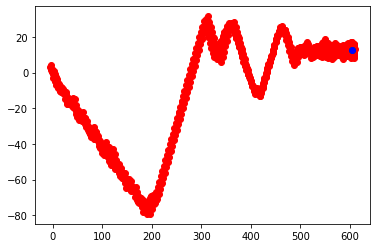

In [64]:
## MOSTRAR GRAFICO DEL MOVIMIENTO DE LAS PARTICULAS
for part in ciclosParticulas:
  plt.scatter(part[0], part[1], color='red')

plt.scatter(POS_RANDOM_EVALUAR[0], POS_RANDOM_EVALUAR[1], color='green')
plt.scatter(mejorPart[0], mejorPart[1], color='blue')

plt.show()